# 📈 Stock Price Movement Prediction with ML (PLTR)

In this notebook, we will build a **machine learning model to predict next-day stock price movement** for a more niche stock: **PLTR (Palantir Technologies)**.

Instead of using heavily overused stocks like AAPL, PLTR offers a less common but interesting case with strong volatility and growth potential.  

---

## 📌 What We’ll Do

1. **Fetch historical stock prices for PLTR**
2. **Create technical indicators** such as moving averages and volatility
3. **Define the target variable**: next-day movement (up = 1, down = 0)
4. **Split data into training and testing sets** (time-series split)
5. **Train multiple ML models:**
   - Logistic Regression
   - Random Forest
   - SVM
6. **Evaluate models** using:
   - Accuracy
   - ROC-AUC
   - Confusion Matrix
7. **Compare models** and select the best one

---

## 📊 Why Predict Stock Movement?

Stock price prediction is a challenging but valuable problem in quantitative finance. By predicting **probabilities of upward movement**, we can build smarter **ML-informed portfolios** instead of relying only on historical averages.

---

## 🔍 Features Used

We’ll engineer some **basic technical indicators** commonly used in trading:

- **Daily return** → percentage change from previous close
- **5-day moving average (MA5)** → short-term trend
- **10-day moving average (MA10)** → longer trend
- **Rolling 5-day volatility** → recent price variability

These features provide the model with **trend & risk information**.

---

## 🎯 Target Definition

The **target** is a binary variable:

- `1` if the stock goes **up** the next day
- `0` if the stock goes **down** or stays flat

This turns the problem into a **classification task** rather than raw price regression.

---

## 🛠️ Train/Test Split

Since stock prices are time-series data, we **don’t shuffle** the dataset.

- The **first 80% of the data** is used for training.
- The **last 20%** is for testing, simulating how the model performs on unseen future data.

---

## 🤖 Models to Compare

We’ll train **3 different ML models**:

1. **Logistic Regression**  
   - A simple linear model for classification.  
2. **Random Forest**  
   - An ensemble of decision trees, good for non-linear patterns.  
3. **SVM (Support Vector Machine)**  
   - A margin-based classifier that works well for binary classification.

We’ll later compare their **Accuracy** and **ROC-AUC**.

---

## 📈 Evaluation Metrics

We’ll evaluate each model using:

- **Accuracy** → percentage of correctly predicted up/down movements
- **ROC-AUC** → how well the model separates upward vs downward movements
- **Confusion Matrix** → detailed breakdown of predictions

These metrics help identify if the model is actually better than a naive baseline (like always predicting “up”).

---

## ✅ Summary & Next Steps

After training and comparing the models, we’ll:

- Pick the **best model** (highest ROC-AUC)
- Visualize its confusion matrix
- Discuss how predictions could feed into a **dynamic portfolio optimization**

Future improvements:
- Add advanced features (RSI, MACD, Bollinger Bands)
- Try more powerful models (XGBoost, LSTM)
- Combine multiple stocks into a **model-driven portfolio**

---

💡 **Why PLTR?**  
PLTR is a volatile, growth-focused stock with strong recent data patterns—making it an interesting candidate for ML-based short-term trend prediction.


In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB



In [22]:
ticker = "PLTR"
data = yf.download(ticker, start="2020-01-01")['Close']
returns = data.pct_change()


C:\Users\Liam Sydney\AppData\Local\Temp\ipykernel_26608\2703597838.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01")['Close']
[*********************100%***********************]  1 of 1 completed


In [23]:
df = pd.DataFrame(index=data.index)
df['close'] = data
df['return'] = returns
df['ma5'] = data.rolling(5).mean()
df['ma10'] = data.rolling(10).mean()
df['volatility'] = returns.rolling(5).std()

# Fill/Drop NaNs
df = df.dropna()


In [24]:
df['target'] = (df['return'].shift(-1) > 0).astype(int)  # 1 if next day up, else 0
df = df.dropna()

features = ['return','ma5','ma10','volatility']
X = df[features]
y = df['target']


In [25]:
# No shuffling because time series
split = int(len(X)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Scale features for models like LogisticRegression & SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [26]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=4),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

results = {}

for name, model in models.items():
    if name in ["Random Forest", "XGBoost", "KNN", "Naive Bayes"]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:,1]
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:,1]
    
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    results[name] = (acc, roc)


In [27]:
for name, (acc, roc) in results.items():
    print(f"{name}: Accuracy={acc:.3f}, ROC-AUC={roc:.3f}")


Logistic Regression: Accuracy=0.418, ROC-AUC=0.496
Random Forest: Accuracy=0.435, ROC-AUC=0.514
SVM: Accuracy=0.414, ROC-AUC=0.569
XGBoost: Accuracy=0.423, ROC-AUC=0.483
KNN: Accuracy=0.406, ROC-AUC=0.513
Naive Bayes: Accuracy=0.423, ROC-AUC=0.514


Best Model: SVM


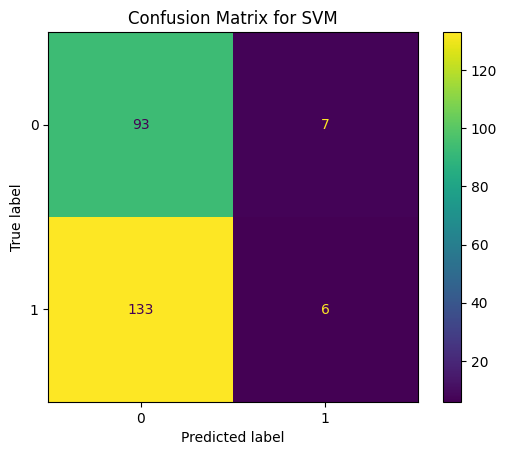

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

# Find best model by ROC-AUC
best_model_name = max(results, key=lambda x: results[x][1])
print("Best Model:", best_model_name)
best_model = models[best_model_name]

# Models that don't need scaling
no_scale_models = ["Random Forest", "XGBoost", "KNN", "Naive Bayes"]

# Predict using correct input
if best_model_name in no_scale_models:
    y_best_pred = best_model.predict(X_test)
else:
    y_best_pred = best_model.predict(X_test_scaled)

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_best_pred)
plt.title(f"Confusion Matrix for {best_model_name}")
plt.show()


In [31]:
from sklearn.metrics import classification_report

# Find best model by ROC-AUC
best_model_name = max(results, key=lambda x: results[x][1])
print("Best Model:", best_model_name)
best_model = models[best_model_name]

# Models that don't need scaling
no_scale_models = ["Random Forest", "XGBoost", "KNN", "Naive Bayes"]

# Predict correctly based on model type
if best_model_name in no_scale_models:
    y_best_pred = best_model.predict(X_test)
else:
    y_best_pred = best_model.predict(X_test_scaled)

# Print classification report for best model
print(f"=== Classification Report for {best_model_name} ===")
print(classification_report(y_test, y_best_pred, target_names=["Down","Up"]))


Best Model: SVM
=== Classification Report for SVM ===
              precision    recall  f1-score   support

        Down       0.41      0.93      0.57       100
          Up       0.46      0.04      0.08       139

    accuracy                           0.41       239
   macro avg       0.44      0.49      0.32       239
weighted avg       0.44      0.41      0.28       239



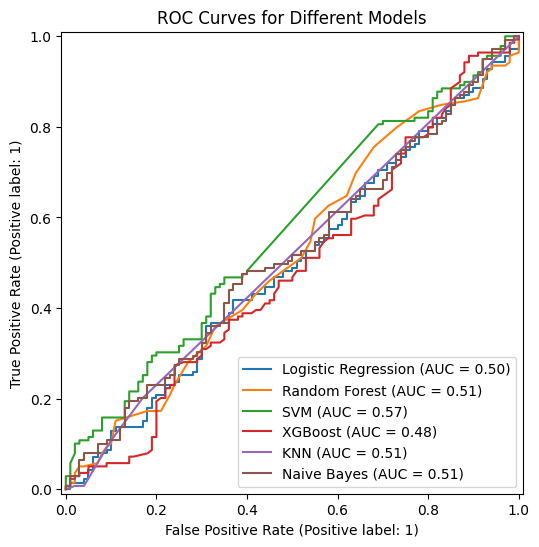

In [32]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(8,6))

# Models that don't need scaling
no_scale_models = ["Random Forest", "XGBoost", "KNN", "Naive Bayes"]

for name, model in models.items():
    if name in no_scale_models:
        y_prob = model.predict_proba(X_test)[:,1]
    else:
        y_prob = model.predict_proba(X_test_scaled)[:,1]
    
    RocCurveDisplay.from_predictions(y_test, y_prob, name=name, ax=ax)

plt.title("ROC Curves for Different Models")
plt.show()



=== Logistic Regression Feature Importance ===


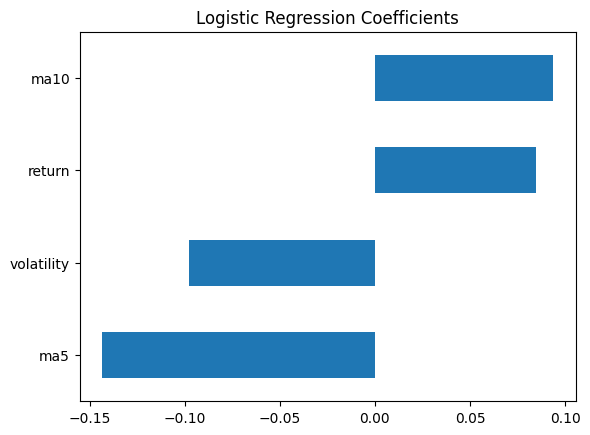


=== Random Forest Feature Importance ===


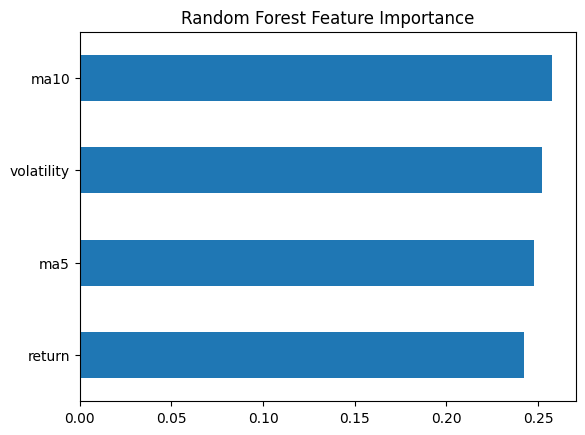


=== SVM Feature Importance ===
SVM does not provide feature importances (skipping).

=== XGBoost Feature Importance ===


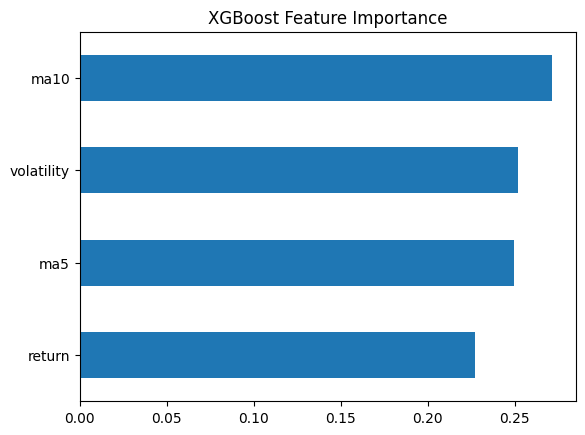


=== KNN Feature Importance ===
KNN does not provide feature importances (skipping).

=== Naive Bayes Feature Importance ===
Naive Bayes does not provide feature importances (skipping).


In [37]:
# Models with tree-based feature importance
tree_models = ["Random Forest", "XGBoost"]

# Loop through models & plot available feature importance
for name, model in models.items():
    print(f"\n=== {name} Feature Importance ===")
    
    # Tree-based models
    if name in tree_models:
        importances = model.feature_importances_
        pd.Series(importances, index=features).sort_values().plot(kind='barh', title=f"{name} Feature Importance")
        plt.show()
    
    # Logistic Regression coefficients
    elif name == "Logistic Regression":
        coeffs = model.coef_[0]
        pd.Series(coeffs, index=features).sort_values().plot(kind='barh', title=f"{name} Coefficients")
        plt.show()
    
    # Models without feature importance
    else:
        print(f"{name} does not provide feature importances (skipping).")


In [36]:
compare_df = pd.DataFrame(results, index=["Accuracy","ROC-AUC"]).T
compare_df.sort_values("ROC-AUC", ascending=False)


,Accuracy,ROC-AUC
SVM,0.414226,0.569137
Random Forest,0.435146,0.514424
Naive Bayes,0.422594,0.513741
KNN,0.405858,0.513094
Logistic Regression,0.418410,0.496115
XGBoost,0.422594,0.482554


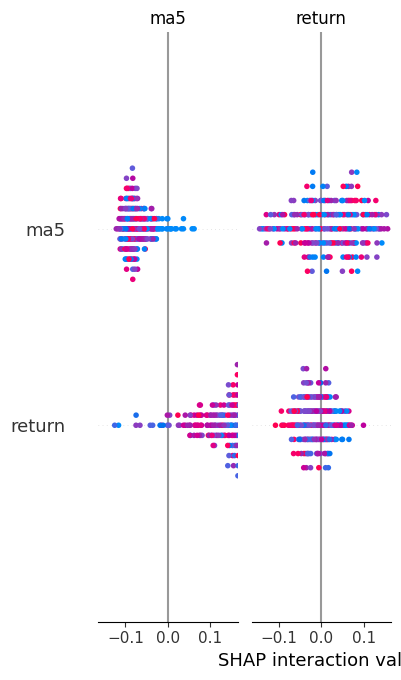

In [38]:
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)



In [39]:
latest_features = X_test.iloc[-1].values.reshape(1,-1)
latest_scaled = scaler.transform(latest_features)

# Use best model
best_model_name = max(results, key=lambda x: results[x][1])
best_model = models[best_model_name]

if best_model_name == "Random Forest":
    prob_up = best_model.predict_proba(latest_features)[:,1][0]
else:
    prob_up = best_model.predict_proba(latest_scaled)[:,1][0]

print(f"Next-day UP probability for PLTR: {prob_up:.2%}")


Next-day UP probability for PLTR: 47.63%


C:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
